In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression

In [27]:
df1 = pd.read_csv('olist_orders_dataset.csv')
df2 = pd.read_csv('olist_customers_dataset.csv')
df3 = pd.read_csv('olist_order_payments_dataset.csv')

In [28]:
cols = ['customer_id', 'order_id', 'order_purchase_timestamp', 'order_status']
orders = df1[cols]
orders =  orders.set_index('customer_id')
orders.drop_duplicates(inplace=True)

cols = ['order_id', 'payment_value']
payment = df3[cols]
payment = payment.set_index('order_id')
payment.drop_duplicates(inplace=True)

cols = ['customer_id', 'customer_unique_id']
customers = df2[cols]
customers = customers.set_index('customer_id')

elog=pd.concat([orders,customers], axis=1, join='inner')
elog.reset_index(inplace=True)

cols = ['customer_unique_id', 'order_purchase_timestamp', 'order_status']
elog = elog[cols]

elog['order_purchase_timestamp'] = pd.to_datetime(elog['order_purchase_timestamp'])
elog['order_date'] = elog.order_purchase_timestamp.dt.date
elog['order_date'] = pd.to_datetime(elog['order_date'])

cols = ['customer_unique_id', 'order_date', 'order_status']
elog = elog[cols]

elog.columns = ['Customer ID', 'Order_Date', 'Order_Status' ]

elog.info()
display(elog.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 3 columns):
Customer ID     99441 non-null object
Order_Date      99441 non-null datetime64[ns]
Order_Status    99441 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 2.3+ MB


,Customer ID,Order_Date,Order_Status
89089,2f9ef3853b1becbbf597c2d7927112c1,2017-12-26,delivered
20816,80b5ded033acdf0dbbf95d15d1fd1c19,2018-07-20,delivered
8232,30b25e94cd8582e92ef193531bc531b8,2017-09-03,delivered
79831,4831f388aaf5dfed43c1bd4455f37eac,2017-01-18,delivered
56165,6f1ba5e4978c1905115578217b12edc7,2017-06-18,delivered


In [29]:
p = payment.aggregate(['sum','count', 'max'])
print(p)

       payment_value
sum       7773585.14
count       29077.00
max         13664.08


In [30]:
first_merge = pd.merge(df1,df3, on = 'order_id')
cols = ['customer_id', 'order_id', 'order_purchase_timestamp', 'payment_value', 'order_status']
first_merge = first_merge[cols]

first_merge['order_purchase_timestamp'] = pd.to_datetime(first_merge['order_purchase_timestamp'])
first_merge['order_purchase_timestamp'] = first_merge.order_purchase_timestamp.dt.date
first_merge['order_purchase_timestamp'] = pd.to_datetime(first_merge['order_purchase_timestamp'])

first_merge.columns = ['customer_id', 'order_id', 'order_date', 'sales', 'order_status']

first_merge.info
display(first_merge.sample(5))

,customer_id,order_id,order_date,sales,order_status
59151,a87b390cf9b1dfb4b06d218502d27ffb,64b0d9816689f0f4dd0f06127d5d0dfb,2018-06-02,134.13,delivered
93173,d9983bf03f76f720635b689e1de6059c,068c0507e1af74b156beee1db2deed7a,2017-06-26,104.34,shipped
36541,ec7529362d2858e7a58c5f4f7f63b999,143bfc6b9cf902d763549e6764121aaf,2018-05-15,43.91,delivered
31560,9a3f52e1bec201f8966f6d0a8faddbb4,1b46c5cd349b4c1e7bda383bb8d64731,2017-07-17,1253.86,delivered
29667,4b3c1094a07e52f1eed9e326d4f28fd9,74f5ef24910641ee05e708ad84525bb7,2017-05-07,116.94,delivered


In [31]:
second_merge = pd.merge(first_merge,df2, on = 'customer_id')
cols = ['customer_unique_id', 'order_id', 'order_date', 'sales', 'order_status']
second_merge = second_merge[cols]



second_merge.columns = ['Customer ID', 'Order ID', 'Order Date', 'Sales', 'Order Status']

second_merge.info
display(second_merge.sample(5))

,Customer ID,Order ID,Order Date,Sales,Order Status
94294,9824bdf343ddb820786bd0fb2d09ee58,fbd969aaf28de4524d590d37fd10b894,2018-07-03,92.73,delivered
102561,20a59a580072e53689c129052ce1c465,41481f110ca58f4d3ee2e077d0313ff3,2017-12-29,57.09,delivered
60353,af999d9279d4befda914eca18a9c0251,cc2d9c1811f602978ee856e76bff969a,2018-01-05,72.00,delivered
89416,fe66f2dac30ccd7cba407f0135c9cf17,b7e27e42f8977f361d7a169003a0bd51,2017-05-23,82.20,delivered
26324,e3170caa179176b49f1265ffde5c27fc,d4de2912c79702221bd12d642b18e49f,2018-01-29,558.92,delivered


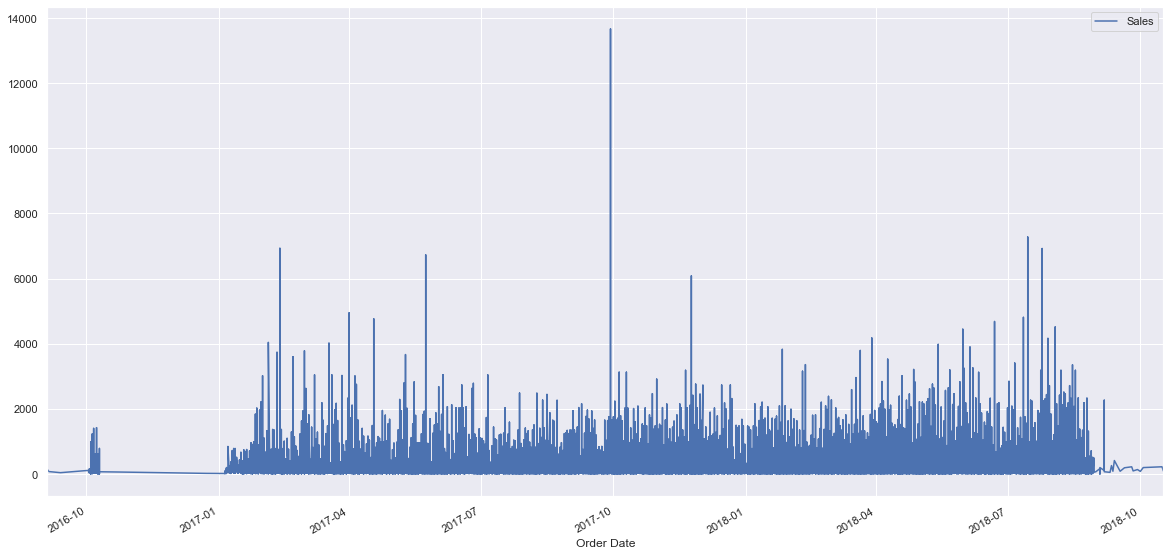

In [32]:
second_merge.groupby('Sales').agg(['sum']).reset_index()
second_merge.plot(figsize=(20,10), x='Order Date', y='Sales',kind="line")
plt.show()

In [33]:
df_RFM = second_merge.groupby('Customer ID').agg({'Order Date': lambda y: (second_merge['Order Date'].max().date() - y.max().date()).days,
                                              'Order ID': 'count',  
                                              'Sales': lambda y: round(y.sum(),2)})

df_RFM.columns = ['Recency', 'Frequency', 'Monetary']
df_RFM = df_RFM.sort_values('Monetary', ascending=False)
df_RFM.head() 

,Recency,Frequency,Monetary
Customer ID,,,
0a0a92112bd4c708ca5fde585afaa872,383,1,13664.08
46450c74a0d8c5ca9395da1daac6c120,61,3,9553.02
da122df9eeddfedc1dc1f5349a1a690c,564,2,7571.63
763c8b1c9c68a0229c42c9fc6f662b93,94,1,7274.88
dc4802a71eae9be1dd28f5d788ceb526,612,1,6929.31


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1dcca400>,
      dtype=object)

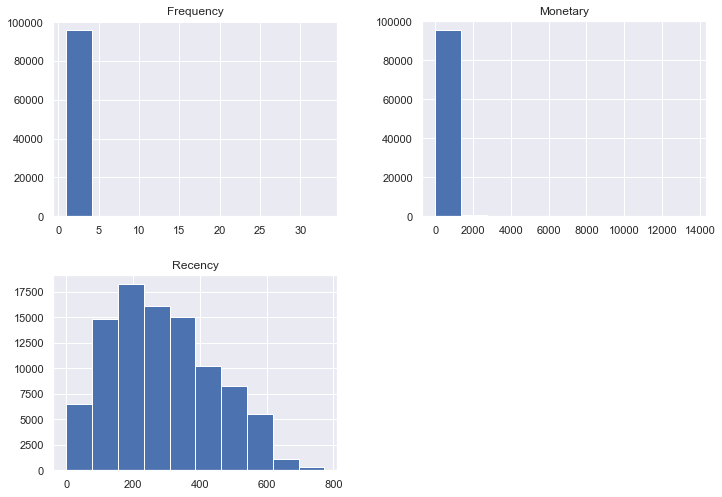

In [35]:
df_RFM.hist()

In [9]:
quantiles = df_RFM.quantile(q=[0.8])
print(quantiles)
df_RFM['R']=np.where(df_RFM['Recency']<=int(quantiles.Recency.values), 2, 1)
df_RFM['F']=np.where(df_RFM['Frequency']>=int(quantiles.Frequency.values), 2, 1)
df_RFM['M']=np.where(df_RFM['Monetary']>=int(quantiles.Monetary.values), 2, 1)
df_RFM.head()

     Recency  Frequency  Monetary
0.8    433.0        1.0   209.604


,Recency,Frequency,Monetary,R,F,M
Customer ID,,,,,,
0a0a92112bd4c708ca5fde585afaa872,383,1,13664.08,2,2,2
46450c74a0d8c5ca9395da1daac6c120,61,3,9553.02,2,2,2
da122df9eeddfedc1dc1f5349a1a690c,564,2,7571.63,1,2,2
763c8b1c9c68a0229c42c9fc6f662b93,94,1,7274.88,2,2,2
dc4802a71eae9be1dd28f5d788ceb526,612,1,6929.31,1,2,2


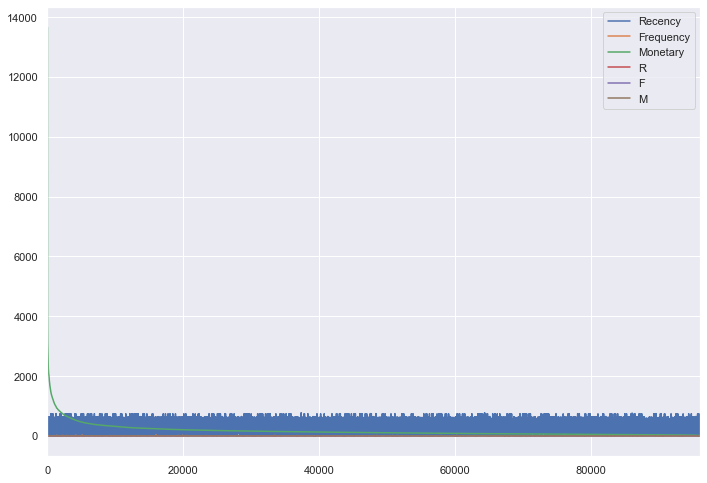

In [25]:
df_RFM.plot()

In [10]:
df_RFM['RMScore'] = df_RFM.M.map(str)+df_RFM.R.map(str)
df_RFM = df_RFM.reset_index()
df_RFM_SUM = df_RFM.groupby('RMScore').agg({'Customer ID': lambda y: len(y.unique()),
                                        'Frequency': lambda y: round(y.mean(),0),
                                        'Recency': lambda y: round(y.mean(),0),
                                        'R': lambda y: round(y.mean(),0),
                                        'M': lambda y: round(y.mean(),0),
                                        'Monetary': lambda y: round(y.mean(),0)})
df_RFM_SUM = df_RFM_SUM.sort_values('RMScore', ascending=False)
df_RFM_SUM.head()

,Customer ID,Frequency,Recency,R,M,Monetary
RMScore,,,,,,
22,15480,1,229,2,2,446.0
21,3844,1,528,1,2,449.0
12,61434,1,229,2,1,97.0
11,15337,1,524,1,1,94.0


Text(0, 0.5, 'Number Customers')

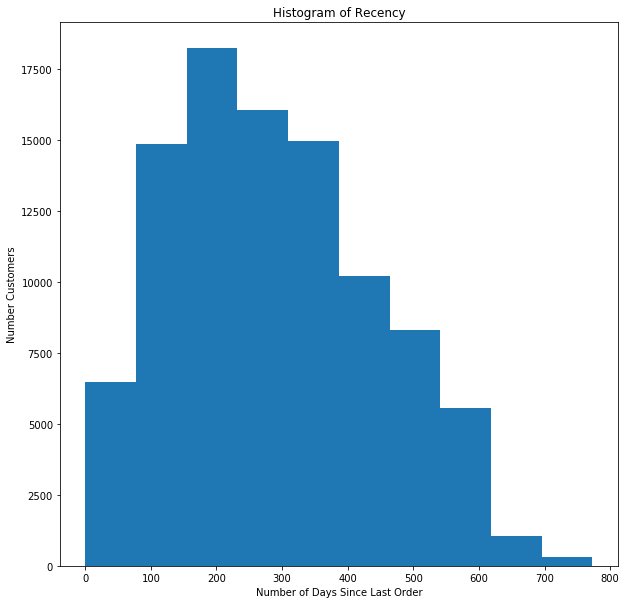

In [11]:
fig = plt.figure(figsize=(10,10)) # define plot area
ax = fig.gca() # define axis    
df_RFM['Recency'].plot.hist(ax = ax) # Use the plot.hist method on subset of the data frame
ax.set_title('Histogram of Recency') # Give the plot a main title
ax.set_xlabel('Number of Days Since Last Order') # Set text for the x axis
ax.set_ylabel('Number Customers')# Set text for y axis

Text(0, 0.5, 'Number Customers')

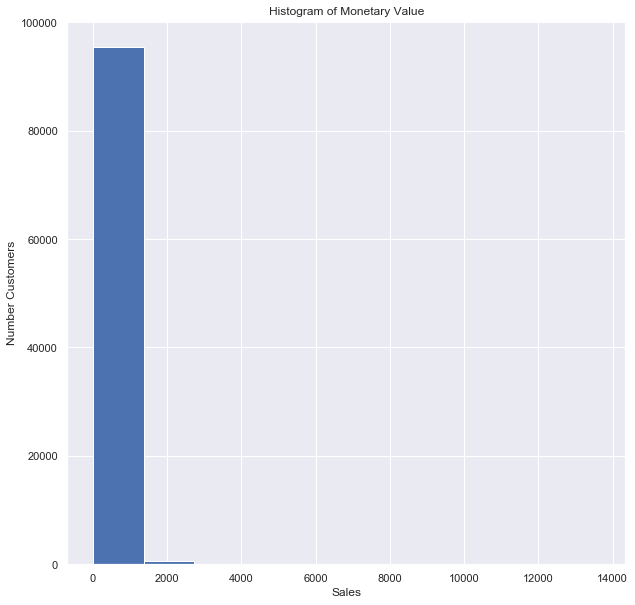

In [23]:
fig = plt.figure(figsize=(10,10)) # define plot area
ax = fig.gca() # define axis    
df_RFM['Monetary'].plot.hist(ax = ax) # Use the plot.hist method on subset of the data frame
ax.set_title('Histogram of Monetary Value') # Give the plot a main title
ax.set_xlabel('Sales') # Set text for the x axis
ax.set_ylabel('Number Customers')# Set text for y axis

Text(0, 0.5, 'Number Customers')

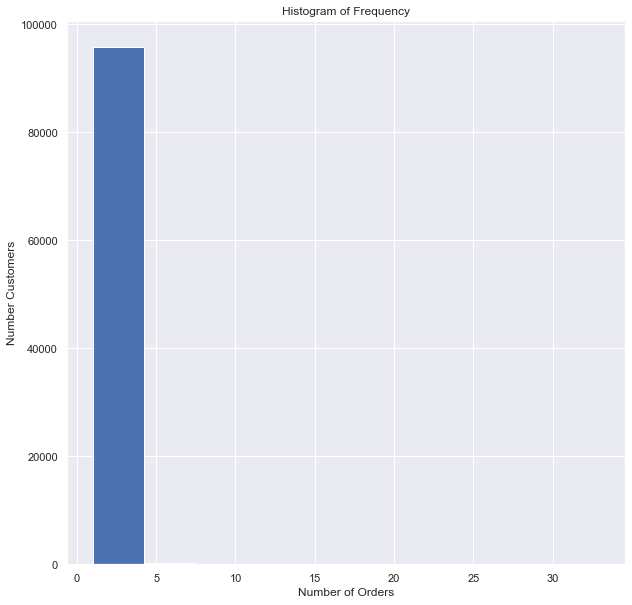

In [24]:
fig = plt.figure(figsize=(10,10)) # define plot area
ax = fig.gca() # define axis    
df_RFM['Frequency'].plot.hist(ax = ax) # Use the plot.hist method on subset of the data frame
ax.set_title('Histogram of Frequency') # Give the plot a main title
ax.set_xlabel('Number of Orders') # Set text for the x axis
ax.set_ylabel('Number Customers')# Set text for y axis

In [12]:
df_RFM_M = df_RFM_SUM.pivot(index='M', columns='R', values='Monetary')
df_RFM_M= df_RFM_M.reset_index().sort_values(['M'], ascending = False).set_index(['M'])
df_RFM_M

R,1,2
M,,
2,449.0,446.0
1,94.0,97.0


In [13]:
df_RFM_C = df_RFM_SUM.pivot(index='M', columns='R', values='Customer ID')
df_RFM_C= df_RFM_C.reset_index().sort_values(['M'], ascending = False).set_index(['M'])
df_RFM_C

R,1,2
M,,
2,3844,15480
1,15337,61434


In [14]:
df_RFM_R = df_RFM_SUM.pivot(index='M', columns='R', values='Recency')
df_RFM_R= df_RFM_R.reset_index().sort_values(['M'], ascending = False).set_index(['M'])
df_RFM_R

R,1,2
M,,
2,528,229
1,524,229


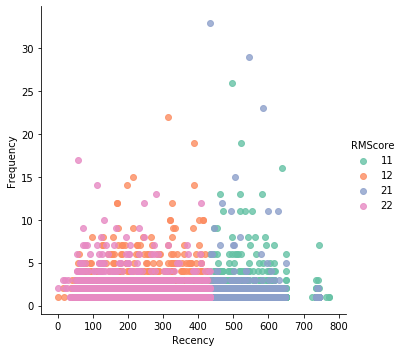

In [15]:
sns.lmplot(x = 'Recency', y = 'Frequency', 
           data = df_RFM, 
           hue = "RMScore", 
           palette="Set2", fit_reg = False)    

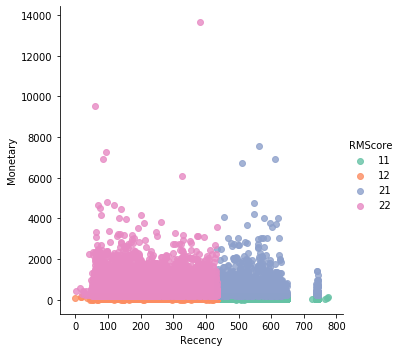

In [16]:
sns.lmplot(x = 'Recency', y = 'Monetary', 
           data = df_RFM, 
           hue = "RMScore", 
           palette="Set2", fit_reg = False) 

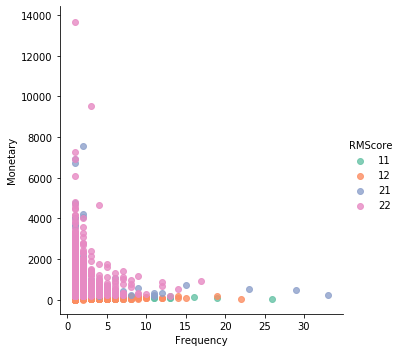

In [17]:
sns.lmplot(x = 'Frequency', y = 'Monetary', 
           data = df_RFM, 
           hue = "RMScore", 
           palette="Set2", fit_reg = False) 

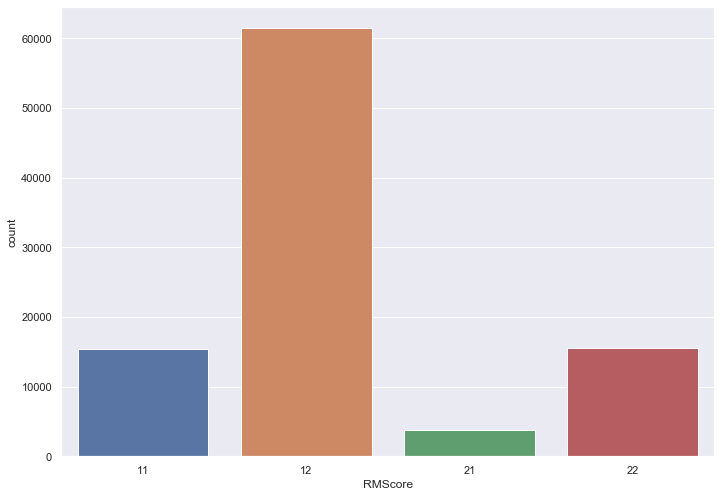

In [18]:
sns.set(rc={'figure.figsize':(11.7,8.27)}, style = 'darkgrid')
ax = sns.countplot(x = 'RMScore', data = df_RFM)

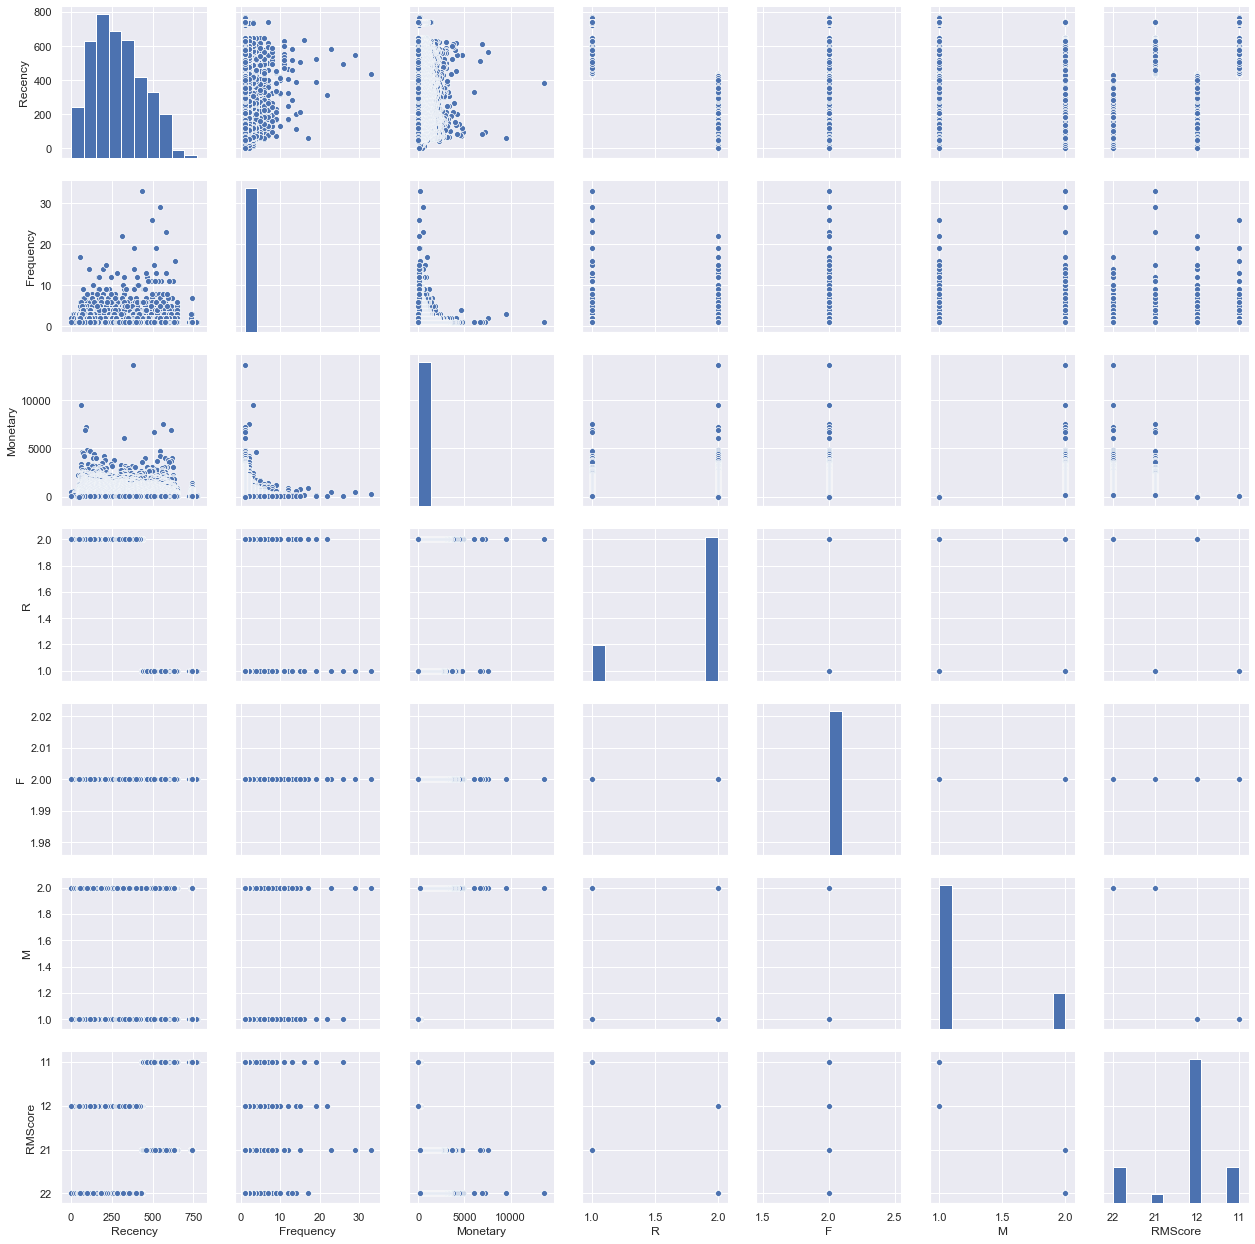

In [22]:
sns.pairplot(df_RFM)